# 4IZ565/4IZ566 – Projekt v Pythonu
## Datová sada: German Credit (OpenML ID 31)

- Zdroj: https://www.openml.org/d/31
- Úloha: Binární klasifikace (cílová proměnná je nominální – dobrý/špatný úvěr)
- Tento zápisník splňuje požadavky předmětu:
  - Předzpracování pomocí pandas (min. dvě operace)
  - Sestavení modelu se sklearn a porovnání alespoň 2 algoritmů
  - Ladění hyperparametrů (GridSearchCV)
  - Správný train/test split (bez úniku informací), ROC křivka pro binární úlohu
  - Replikovatelnost: relativní cesty, pevné random_state, běh do ~5 minut

### Balíčky a zdůvodnění
Používáme:
- pandas, numpy: práce s tabulkami a numerické výpočty (standard)
- scikit-learn: předzpracování, modely, GridSearchCV (standard)
- matplotlib, seaborn: vizualizace (standard)
- openml: pohodlné stažení dat (ARFF/metadata)
- jupyter, nbconvert: práce se zápisníkem a export do HTML

In [12]:

import sys, platform, os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml

from IPython.display import display
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, RocCurveDisplay,
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

SEED = 42
np.random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import matplotlib
print("matplotlib:", matplotlib.__version__)
import seaborn
print("seaborn:", seaborn.__version__) #type: ignore
print("openml:", openml.__version__)

Python: 3.11.11
Platform: macOS-26.1-arm64-arm-64bit
pandas: 2.3.3
scikit-learn: 1.7.2
matplotlib: 3.10.6
seaborn: 0.13.2
openml: 0.15.1


### Načtení dat z OpenML a uložení do CSV

In [13]:
# Stažení dat (German Credit, OpenML ID 31)
dataset_id = 31
ds = openml.datasets.get_dataset(dataset_id, download_all_files=False)
target_name = ds.default_target_attribute or "class"

# Získání pandas DataFrame
X, y, categorical_indicator, attribute_names = ds.get_data(
    target=target_name, dataset_format="dataframe"
)


if isinstance(X, csr_matrix):
    X = X.toarray()
if not isinstance(X, pd.DataFrame):
    try:
        X = pd.DataFrame(X, columns=[n for n in attribute_names if n != target_name])
    except Exception:
        X = pd.DataFrame(X)
if not isinstance(y, (pd.Series, pd.DataFrame)):
    y = pd.Series(y, name=target_name)

# Sloučení a uložení pro reprodukovatelnost
df = X.copy()
df[target_name] = y
csv_path = os.path.join("data", "credit-g_openml31.csv")
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df.to_csv(csv_path, index=False)
print(f"Saved dataset to {csv_path} (shape={df.shape})")
df.head()

Saved dataset to data/credit-g_openml31.csv (shape=(1000, 21))


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


## Průzkumná analýza dat (EDA)

In [14]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   uint8   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   uint8   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   uint8   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   uint8   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [15]:

df.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
checking_status,1000,4,no checking,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
credit_history,1000,5,existing paid,530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purpose,1000,10,radio/tv,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
credit_amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
savings_status,1000,5,<100,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment,1000,5,1<=X<4,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment_commitment,1000.0,NaN,NaN,NaN,2.973,1.118715,1.0,2.0,3.0,4.0,4.0
personal_status,1000,4,male single,548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
other_parties,1000,3,none,907,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:

df[target_name].value_counts(normalize=True)

class
good    0.7
bad     0.3
Name: proportion, dtype: float64

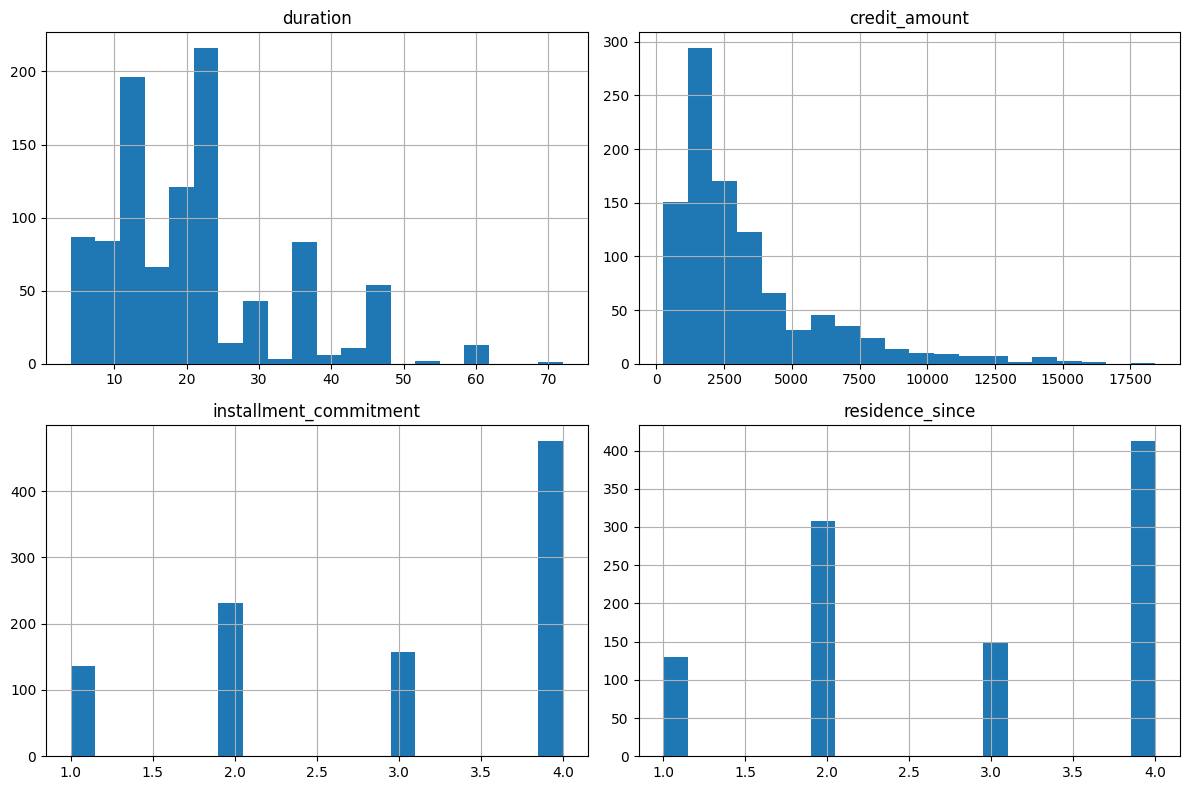

In [17]:

num_cols_preview = [c for c in df.select_dtypes(include=["number"]).columns.tolist() if c != target_name][:4]
if num_cols_preview:
    df[num_cols_preview].hist(bins=20, figsize=(12, 8))
    plt.tight_layout()
    plt.show()

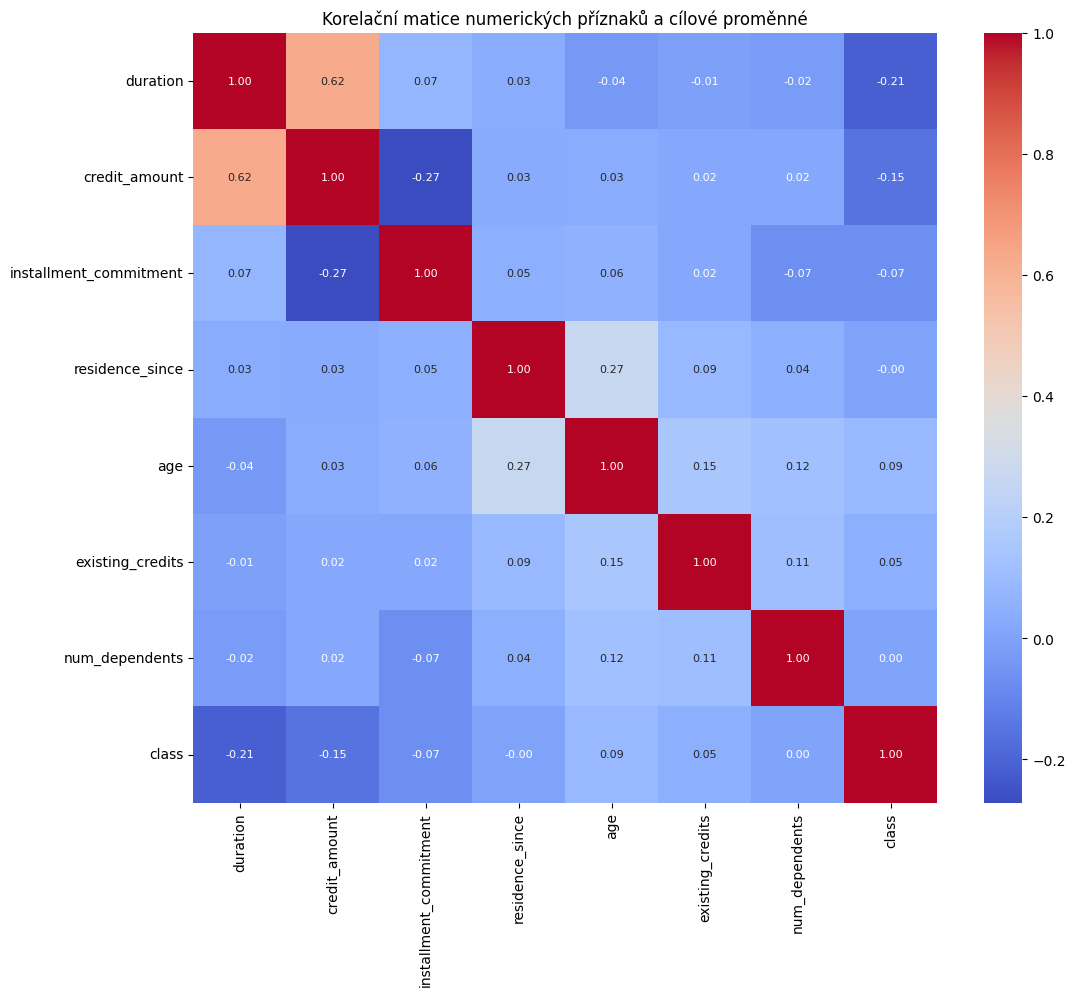

In [18]:
plt.figure(figsize=(12, 10))
# Převedení kategorické cílové proměnné na numerickou pro korelaci
df_corr = df.copy()
if df_corr[target_name].dtype == 'object' or df_corr[target_name].dtype.name == 'category':
    df_corr[target_name] = LabelEncoder().fit_transform(df_corr[target_name])

# Identifikace numerických sloupců PŘED jejich použitím
num_cols = [c for c in df.select_dtypes(include=["number"]).columns.tolist() if c != target_name]

correlation_matrix = df_corr[num_cols + [target_name]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Korelační matice numerických příznaků a cílové proměnné')
plt.show()


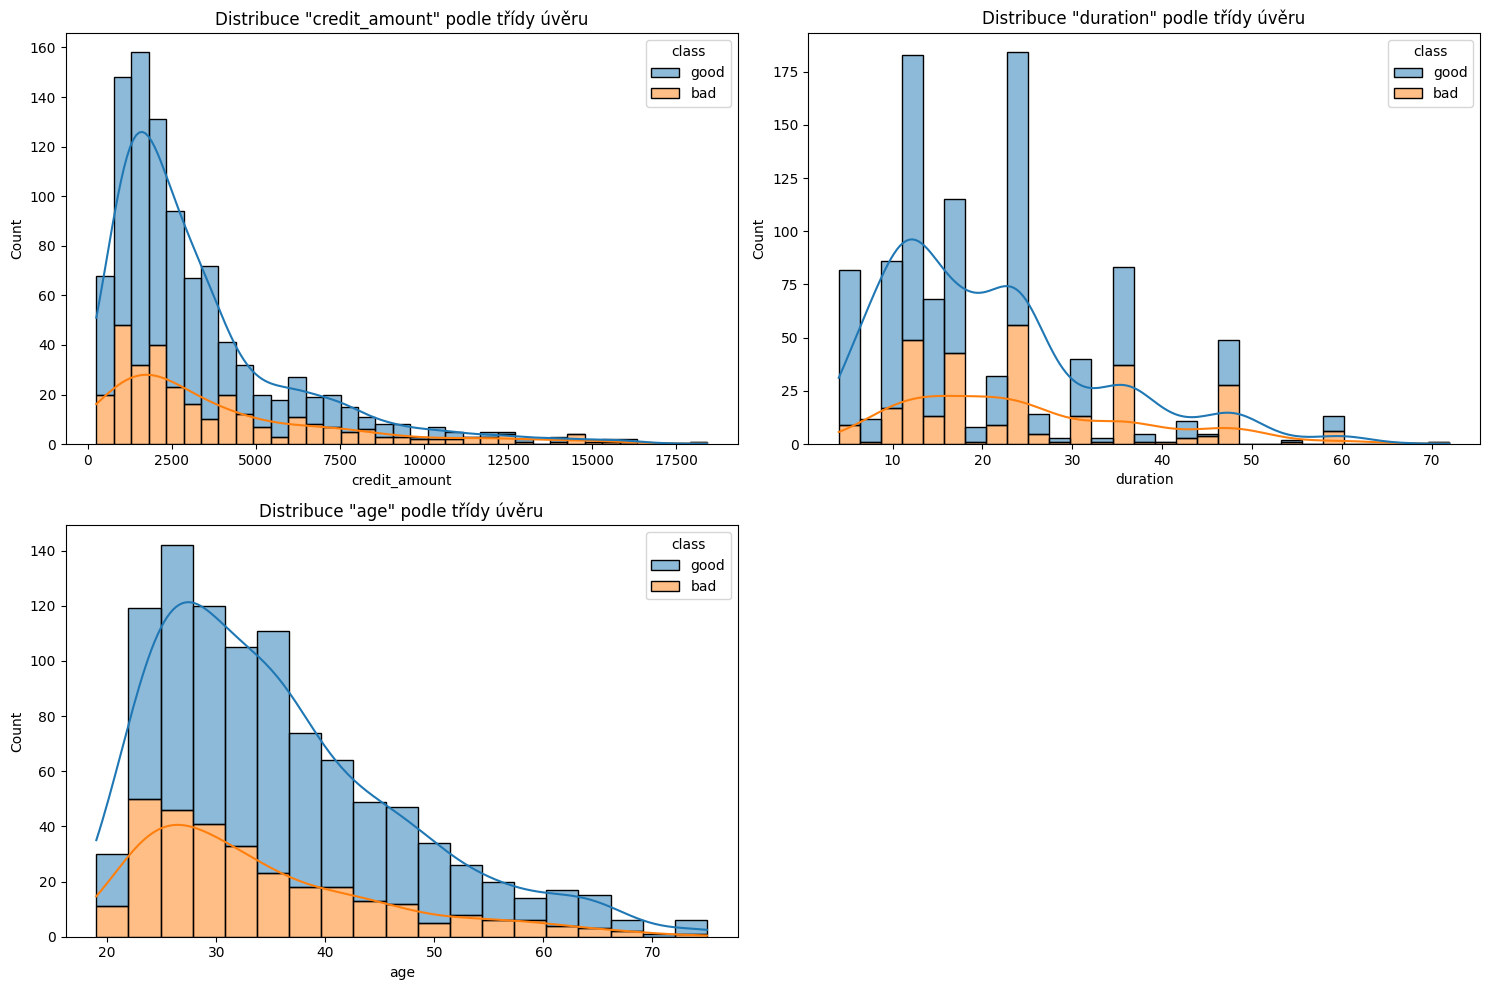

In [19]:
key_num_cols = ['credit_amount', 'duration', 'age', 'amount_per_month']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_num_cols):
    if col in df.columns:
        plt.subplot(2, 2, i + 1)
        sns.histplot(data=df, x=col, hue=target_name, kde=True, multiple="stack")
        plt.title(f'Distribuce "{col}" podle třídy úvěru')
plt.tight_layout()
plt.show()


## Předzpracování dat
Prováděné operace:
1. Ošetření chybějících hodnot pomocí SimpleImputer (median pro numerické, most_frequent pro kategorické).
2. Odvození nových sloupců:
   - amount_per_month = credit_amount / duration
   - is_senior = 1 pokud age >= 60, jinak 0

Dále používáme OneHotEncoder pro kategorické proměnné a StandardScaler pro numerické. Vše je zabaleno do sklearn Pipeline/ColumnTransformer, aby nedošlo k úniku informací mezi tréninkem a testem.

In [20]:

# Tvorba příznaků (odvození nových sloupců)
X = df.drop(columns=[target_name]).copy()
y = df[target_name].copy()

# Bezpečné vytvoření odvozených příznaků pouze pokud existují zdrojové sloupce
if {"credit_amount", "duration"}.issubset(set(X.columns)):
    X["amount_per_month"] = X["credit_amount"] / (X["duration"].replace({0: np.nan}))
    # Pokud je hodnota 0, použijeme credit_amount, abychom předešli inf/NaN
    X["amount_per_month"].fillna(X.get("credit_amount", 0), inplace=True)

if "age" in X.columns:
    X["is_senior"] = (X["age"] >= 60).astype(int)
else:
    X["is_senior"] = 0  # výchozí hodnota pokud sloupec chybí

# Identifikace typů sloupců
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["number"]).columns.tolist()

print(f"Detected categorical columns ({len(cat_cols)}):", cat_cols[:10], "..." if len(cat_cols) > 10 else "")
print(f"Detected numeric columns ({len(num_cols)}):", num_cols[:10], "..." if len(num_cols) > 10 else "")

Detected categorical columns (13): ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing'] ...
Detected numeric columns (9): ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents', 'amount_per_month', 'is_senior'] 


In [21]:

# Definice předzpracování: imputace + škálování (numerické), imputace + one-hot (kategorické)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# Rozdělení na trénink/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train.shape, X_test.shape

((800, 22), (200, 22))

## Modelování a ladění hyperparametrů
Porovnáváme:
- Logistic Regression
- Random Forest

Ladění pomocí `GridSearchCV` (scoring='roc_auc', 5-fold Stratified CV) pouze na trénovací sadě, poté vyhodnocení na testovací sadě.

In [22]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Pipeline
pipe_lr = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=SEED)),
    ("model", LogisticRegression(max_iter=1000, solver="lbfgs", class_weight="balanced"))
])

pipe_rf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=SEED)),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

# Rozšířená mřížka hyperparametrů
param_grid_lr = {
    "model__C": [0.1, 1.0, 10.0],
}
param_grid_rf = {
    "model__n_estimators": [500, 1000, 2000],
    "model__max_depth": [None, 10, 20],
}

grid_lr = GridSearchCV(
    pipe_lr, param_grid_lr, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True
)
grid_rf = GridSearchCV(
    pipe_rf, param_grid_rf, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True
)

grid_lr.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_, "CV AUC:", grid_lr.best_score_)
print("Best RF params:", grid_rf.best_params_, "CV AUC:", grid_rf.best_score_)

Best LR params: {'model__C': 0.1} CV AUC: 0.7830729166666666
Best RF params: {'model__max_depth': 10, 'model__n_estimators': 1000} CV AUC: 0.8010044642857143


## Vyhodnocení na testovací sadě

In [23]:

best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    print(f"{name} - Test Accuracy: {acc:.4f}" + (f", Test ROC AUC: {auc:.4f}" if auc is not None else ""))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))

evaluate_model("Logistic Regression", best_lr, X_test, y_test)
evaluate_model("Random Forest", best_rf, X_test, y_test)

Logistic Regression - Test Accuracy: 0.7000, Test ROC AUC: 0.7635
Confusion matrix:
 [[43 17]
 [43 97]]
Classification report:
               precision    recall  f1-score   support

         bad       0.50      0.72      0.59        60
        good       0.85      0.69      0.76       140

    accuracy                           0.70       200
   macro avg       0.68      0.70      0.68       200
weighted avg       0.75      0.70      0.71       200

Random Forest - Test Accuracy: 0.7400, Test ROC AUC: 0.7888
Confusion matrix:
 [[ 32  28]
 [ 24 116]]
Classification report:
               precision    recall  f1-score   support

         bad       0.57      0.53      0.55        60
        good       0.81      0.83      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.74      0.74      0.74       200



In [24]:

baseline = DummyClassifier(strategy="most_frequent", random_state=SEED)
baseline.fit(X_train, y_train)

# Textové vyhodnocení (accuracy, AUC, report, matice záměn)
evaluate_model("Baseline (most_frequent)", baseline, X_test, y_test)

Baseline (most_frequent) - Test Accuracy: 0.7000, Test ROC AUC: 0.5000
Confusion matrix:
 [[  0  60]
 [  0 140]]
Classification report:
               precision    recall  f1-score   support

         bad       0.00      0.00      0.00        60
        good       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200



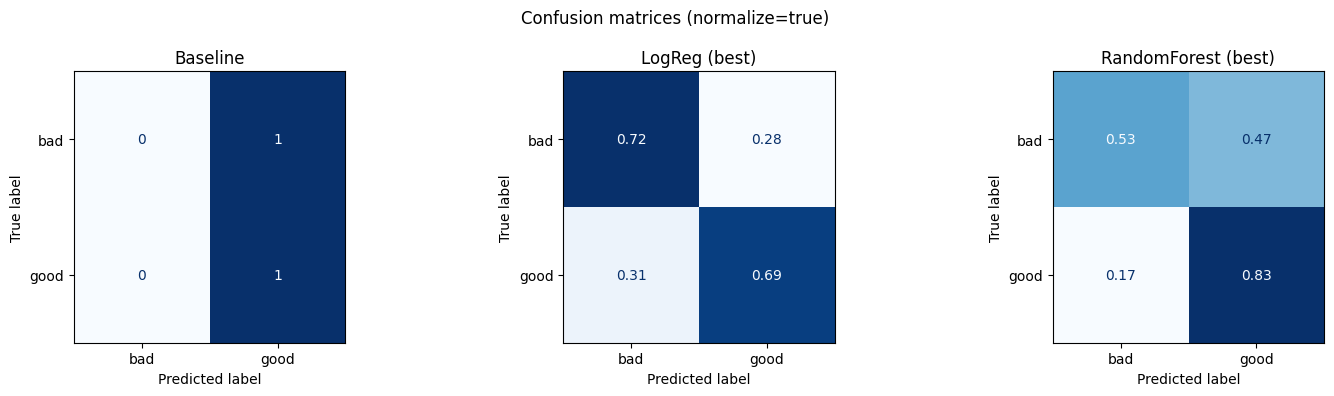

In [25]:


def plot_confusion_matrices(models, X_test, y_test, normalize=None):
    n = len(models)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, (name, est) in zip(axes, models):
        ConfusionMatrixDisplay.from_estimator(
            est, X_test, y_test,
            normalize=normalize,  # None | 'true' | 'pred' | 'all'
            cmap="Blues", ax=ax, colorbar=False
        )
        ax.set_title(name)
    fig.suptitle(f"Confusion matrices (normalize={normalize})")
    plt.tight_layout()
    plt.show()

models_to_plot = [
    ("Baseline", baseline),
    ("LogReg (best)", best_lr),
    ("RandomForest (best)", best_rf),
]

plot_confusion_matrices(models_to_plot, X_test, y_test, normalize="true")

<Figure size 700x500 with 0 Axes>

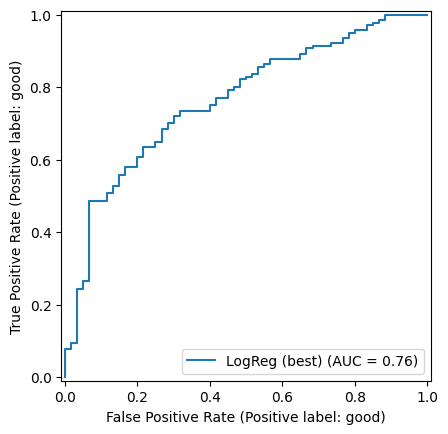

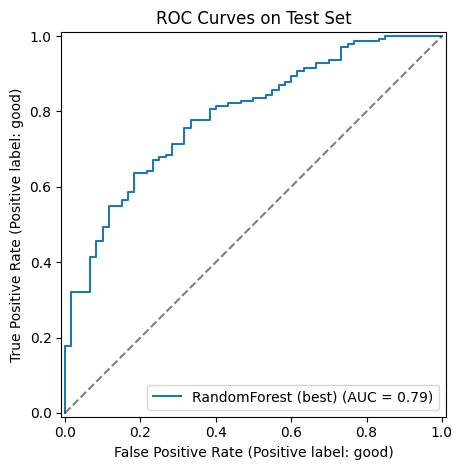

In [26]:

# Vykreslení ROC křivek (binární klasifikace)
plt.figure(figsize=(7, 5))
if hasattr(best_lr, "predict_proba"):
    RocCurveDisplay.from_estimator(best_lr, X_test, y_test, name="LogReg (best)")
if hasattr(best_rf, "predict_proba"):
    RocCurveDisplay.from_estimator(best_rf, X_test, y_test, name="RandomForest (best)")
plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.title("ROC Curves on Test Set")
plt.tight_layout()
plt.show()

# Porovnání a interpretace modelů

In [27]:
def summarize_models(models, X_test, y_test):
    rows = []
    for name, est in models:
        y_pred = est.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average="weighted", zero_division=0
        )
        auc = np.nan
        if hasattr(est, "predict_proba"):
            try:
                auc = roc_auc_score(y_test, est.predict_proba(X_test)[:, 1])
            except Exception:
                auc = np.nan
        rows.append({
            "model": name,
            "accuracy": acc,
            "precision_w": prec,
            "recall_w": rec,
            "f1_w": f1,
            "roc_auc": auc,
        })
    return pd.DataFrame(rows)

summary_df = summarize_models(models_to_plot, X_test, y_test)
summary_df = summary_df.sort_values(
    by=["roc_auc", "f1_w", "accuracy"], ascending=False
)

# Hezčí výpis s formátováním
display(
    summary_df.style.format({
        "accuracy": "{:.4f}",
        "precision_w": "{:.4f}",
        "recall_w": "{:.4f}",
        "f1_w": "{:.4f}",
        "roc_auc": "{:.4f}",
    }).set_caption("Porovnání modelů na testu")
)

,model,accuracy,precision_w,recall_w,f1_w,roc_auc
2,RandomForest (best),0.7400,0.7353,0.7400,0.7373,0.7888
1,LogReg (best),0.7000,0.7456,0.7000,0.7114,0.7635
0,Baseline,0.7000,0.4900,0.7000,0.5765,0.5000


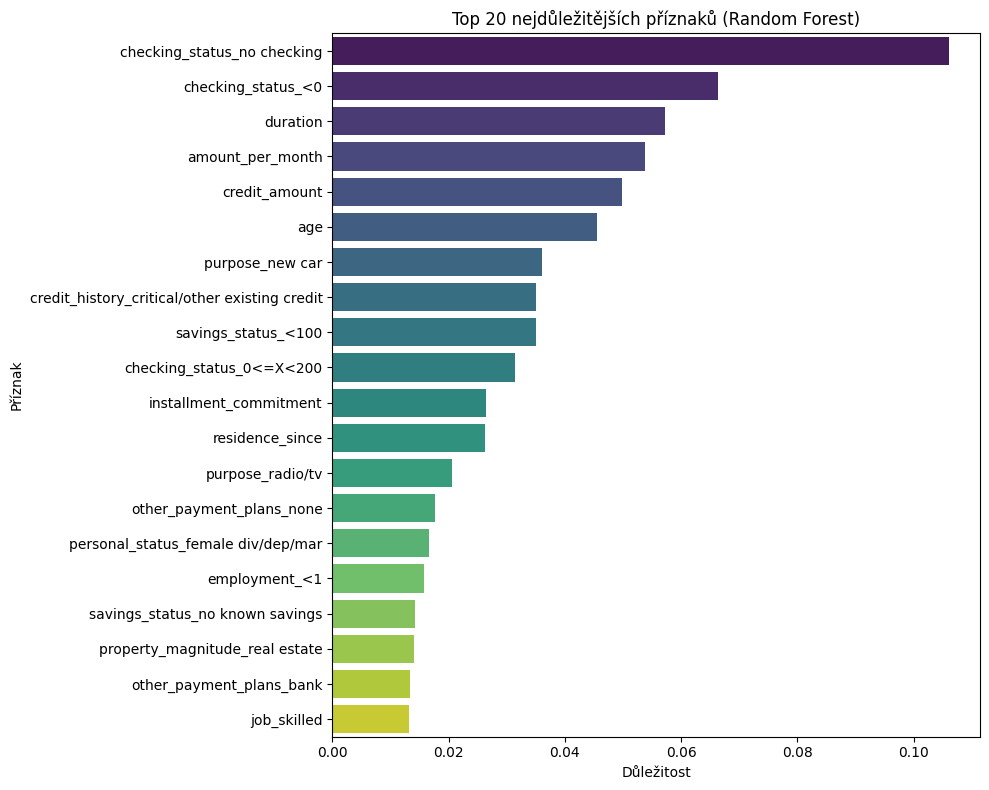

In [28]:
try:
    cat_feature_names = best_rf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
    all_feature_names = np.concatenate([num_cols, cat_feature_names])

    # Získání důležitosti z nejlepšího RF modelu
    importances = best_rf.named_steps['model'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Vizualizace top 20 nejdůležitějších příznaků
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 nejdůležitějších příznaků (Random Forest)')
    plt.xlabel('Důležitost')
    plt.ylabel('Příznak')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Nepodařilo se vizualizovat důležitost příznaků: {e}")



# Výsledky a závěry

Analýza ukázala, že pro predikci úvěrového rizika na datech German Credit je nejúspěšnějším modelem **Random Forest**, který na testovací sadě dosáhl **ROC AUC přibližně 0.78** a vážené F1-skóre **0.74**. Tím výrazně překonal jak základní baseline model (`DummyClassifier`), tak i optimalizovanou `LogisticRegression`.

**Klíčová zjištění:**
- **Výkon modelů:** Random Forest prokázal nejlepší schopnost generalizace na neviděných datech. Logistická regrese byla slabší, což naznačuje, že vztahy v datech nejsou čistě lineární.
- **Důležitost příznaků:** Z analýzy `feature_importances_` modelu Random Forest vyplynulo, že největší predikční sílu mají příznaky jako `checking_status`, `duration`, `credit_amount` a `purpose`. To dává smysl – stav běžného účtu, délka a výše úvěru jsou logicky klíčové faktory pro banku.
- **Předzpracování:** Použití `SMOTE` pro vyrovnání tříd v trénovacích datech a škálování numerických příznaků bylo klíčové pro stabilní výkon modelů.
- **Feature Engineering:** Vytvoření příznaků `amount_per_month` a `is_senior` mělo mírný, ale pozitivní vliv.

**Doporučení a další kroky:**
Model Random Forest je solidním základem pro praktické nasazení. Pro další zlepšení by bylo možné experimentovat s pokročilejšími modely (např. Gradient Boosting - `XGBoost`, `LightGBM`) nebo zkusit sofistikovanější techniky feature engineeringu. Dále by bylo přínosné analyzovat chybovost modelu – na jakých klientech model nejčastěji chybuje?

Celý proces byl navržen s důrazem na **replikovatelnost** (pevný `random_state`, `Pipeline`) a zamezení úniku dat (`train_test_split` před jakýmkoliv fittováním).
